# What is the notebook about?

## Problem - Taxi Environment Algorithms
This problem deals with a taxi environment and stochastic actions. The tasks you have to do are:
- Implement Policy Iteration
- Implement Modified Policy Iteration
- Implement Value Iteration
- Implement Gauss Seidel Value Iteration
- Visualize the results
- Explain the results

## How to use this notebook? 📝

- This is a shared template and any edits you make here will not be saved.**You
should make a copy in your own drive**. Click the "File" menu (top-left), then "Save a Copy in Drive". You will be working in your copy however you like.

- **Update the config parameters**. You can define the common variables here

Variable | Description
--- | ---
`AICROWD_DATASET_PATH` | Path to the file containing test data. This should be an absolute path.
`AICROWD_RESULTS_DIR` | Path to write the output to.
`AICROWD_ASSETS_DIR` | In case your notebook needs additional files (like model weights, etc.,), you can add them to a directory and specify the path to the directory here (please specify relative path). The contents of this directory will be sent to AIcrowd for evaluation.
`AICROWD_API_KEY` | In order to submit your code to AIcrowd, you need to provide your account's API key. This key is available at https://www.aicrowd.com/participants/me

- **Installing packages**. Please use the [Install packages 🗃](#install-packages-) section to install the packages

# Setup AIcrowd Utilities 🛠

We use this to bundle the files for submission and create a submission on AIcrowd. Do not edit this block.

In [1]:
!pip install aicrowd-cli > /dev/null 

ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


# AIcrowd Runtime Configuration 🧷

Get login API key from https://www.aicrowd.com/participants/me

In [2]:
import os

AICROWD_DATASET_PATH = os.getenv("DATASET_PATH", os.getcwd()+"/13d77bb0-b325-4e95-a03b-833eb6694acd_a2_taxi_inputs.zip")
AICROWD_RESULTS_DIR = os.getenv("OUTPUTS_DIR", "results")


API Key valid
Saved API Key successfully!
13d77bb0-b325-4e95-a03b-833eb6694acd_a2_taxi_inputs.zip: 100% 31.2k/31.2k [00:00<00:00, 340kB/s]


In [4]:
!unzip $AICROWD_DATASET_PATH

Archive:  /content/13d77bb0-b325-4e95-a03b-833eb6694acd_a2_taxi_inputs.zip
   creating: inputs/
  inflating: inputs/inputs_base.npy  
  inflating: inputs/inputs_1.npy     
  inflating: inputs/inputs_0.npy     
  inflating: inputs/inputs_2.npy     
   creating: targets/
  inflating: targets/targets_2.npy   
  inflating: targets/targets_0.npy   
  inflating: targets/targets_1.npy   
  inflating: targets/targets_base.npy  


In [5]:
DATASET_DIR = 'inputs/'

## Taxi Environment

Read the environment to understand the functions, but do not edit anything

In [6]:
import numpy as np

class TaxiEnv_HW2:
    def __init__(self, states, actions, probabilities, rewards, initial_policy):
        self.possible_states = states
        self._possible_actions = {st: ac for st, ac in zip(states, actions)}
        self._ride_probabilities = {st: pr for st, pr in zip(states, probabilities)}
        self._ride_rewards = {st: rw for st, rw in zip(states, rewards)}
        self.initial_policy = initial_policy
        self._verify()

    def _check_state(self, state):
        assert state in self.possible_states, "State %s is not a valid state" % state

    def _verify(self):
        """ 
        Verify that data conditions are met:
        Number of actions matches shape of next state and actions
        Every probability distribution adds up to 1 
        """
        ns = len(self.possible_states)
        for state in self.possible_states:
            ac = self._possible_actions[state]
            na = len(ac)

            rp = self._ride_probabilities[state]
            assert np.all(rp.shape == (na, ns)), "Probabilities shape mismatch"
        
            rr = self._ride_rewards[state]
            assert np.all(rr.shape == (na, ns)), "Rewards shape mismatch"

            assert np.allclose(rp.sum(axis=1), 1), "Probabilities don't add up to 1"

    def possible_actions(self, state):
        """ Return all possible actions from a given state """
        self._check_state(state)
        return self._possible_actions[state]

    def ride_probabilities(self, state, action):
        """ 
        Returns all possible ride probabilities from a state for a given action
        For every action a list with the returned with values in the same order as self.possible_states
        """
        actions = self.possible_actions(state)
        ac_idx = actions.index(action)
        return self._ride_probabilities[state][ac_idx]

    def ride_rewards(self, state, action):
        actions = self.possible_actions(state)
        ac_idx = actions.index(action)
        return self._ride_rewards[state][ac_idx]

## Example of Environment usage

In [7]:
def check_taxienv():
    # These are the values as used in the pdf, but they may be changed during submission, so do not hardcode anything

    states = ['A', 'B', 'C']

    actions = [['1','2','3'], ['1','2'], ['1','2','3']]

    probs = [np.array([[1/2,  1/4,  1/4],
                    [1/16, 3/4,  3/16],
                    [1/4,  1/8,  5/8]]),

            np.array([[1/2,   0,     1/2],
                    [1/16,  7/8,  1/16]]),

            np.array([[1/4,  1/4,  1/2],
                    [1/8,  3/4,  1/8],
                    [3/4,  1/16, 3/16]]),]

    rewards = [np.array([[10,  4,  8],
                        [ 8,  2,  4],
                        [ 4,  6,  4]]),

            np.array([[14,  0, 18],
                        [ 8, 16,  8]]),

            np.array([[10,  2,  8],
                        [6,   4,  2],
                        [4,   0,  8]]),]
    initial_policy = {'A': '1', 'B': '1', 'C': '1'}

    env = TaxiEnv_HW2(states, actions, probs, rewards, initial_policy)
    print("All possible states", env.possible_states)
    print("All possible actions from state B", env.possible_actions('B'))
    print("Ride probabilities from state A with action 2", env.ride_probabilities('A', '2'))
    print("Ride rewards from state C with action 3", env.ride_rewards('C', '3'))

    base_kwargs = {"states": states, "actions": actions, 
                "probabilities": probs, "rewards": rewards,
                "initial_policy": initial_policy}
    return base_kwargs

base_kwargs = check_taxienv()
env = TaxiEnv_HW2(**base_kwargs)

All possible states ['A', 'B', 'C']
All possible actions from state B ['1', '2']
Ride probabilities from state A with action 2 [0.0625 0.75   0.1875]
Ride rewards from state C with action 3 [4 0 8]


## Task 1 - Policy Iteration
Run policy iteration on the environment and generate the policy and expected reward

In [8]:
# 1.1 Policy Iteration
def policy_iteration(taxienv, gamma):
    # A list of all the states
    states = taxienv.possible_states
    # Initial values
    values = {s: 0 for s in states}

    # This is a dictionary of states to policies -> e.g {'A': '1', 'B': '2', 'C': '1'}
    policy = taxienv.initial_policy.copy()

    ## Begin code here

    # Hints - 
    # Do not hardcode anything
    # Only the final result is required for the results
    # Put any extra data in "extra_info" dictonary for any plots etc
    # Use the helper functions taxienv.ride_rewards, taxienv.ride_probabilities,  taxienv.possible_actions
    # For terminating condition use the condition exactly mentioned in the pdf

    
    # Put your extra information needed for plots etc in this dictionary
    extra_info = {}

    ####My Code Start...................#Done

    done = 0
    epsilon = 1e-8
    NIterations = 0

    while(1):
      while(1):
        delta = 0
        for state_i in states:
          j = values[state_i]

          action = policy[state_i]
          probabs = taxienv.ride_probabilities(state_i,action)
          rewards = taxienv.ride_rewards(state_i,action)
          value_tmp = 0
          for enm,state_j in enumerate(states):
            value_tmp+= probabs[enm]*(rewards[enm]+ gamma*values[state_j])
          values[state_i] = value_tmp
          delta = max(delta, abs(j-values[state_i]))
        NIterations+=1
        if(delta<epsilon):
          break
      done= 1
      for state_i in states:
        b = policy[state_i]

        tmp_arr = []
        
        for action in taxienv.possible_actions(state_i):
          probabs = taxienv.ride_probabilities(state_i,action)
          rewards = taxienv.ride_rewards(state_i,action)

          tmp = 0
          for enm,state_j in enumerate(states):
            tmp+= probabs[enm]*(rewards[enm]+ gamma*values[state_j])
          tmp_arr.append(tmp)
        
        policy[state_i]= taxienv.possible_actions(state_i)[np.argmax(tmp_arr)]
        if(b != policy[state_i]):
          done=0
      if(done==1):
        break

    extra_info["NIterations"] = NIterations

    ####My Code End.....................

    ## Do not edit below this line

    # Final results
    return {"Expected Reward": values, "Policy": policy}, extra_info

# Task 2 - Policy Iteration for multiple values of gamma

Ideally this code should run as is

In [9]:
# 1.2 Policy Iteration with different values of gamma
def run_policy_iteration(env):
    gamma_values = np.arange(5, 100, 5)/100
    results, extra_info = {}, {}
    for gamma in gamma_values:
        results[gamma], extra_info[gamma] = policy_iteration(env, gamma)
    return results, extra_info

results, extra_info = run_policy_iteration(env)

# Task 3 - Modifed Policy Iteration

Implement modified policy iteration (where Value iteration is done for fixed m number of steps)

In [10]:
# 1.3 Modified Policy Iteration
def modified_policy_iteration(taxienv, gamma, m):
    # A list of all the states
    states = taxienv.possible_states
    # Initial values
    values = {s: 0 for s in states}

    # This is a dictionary of states to policies -> e.g {'A': '1', 'B': '2', 'C': '1'}
    policy = taxienv.initial_policy.copy()

    ## Begin code here

    # Hints - 
    # Do not hardcode anything
    # Only the final result is required for the results
    # Put any extra data in "extra_info" dictonary for any plots etc
    # Use the helper functions taxienv.ride_rewards, taxienv.ride_probabilities,  taxienv.possible_actions
    # For terminating condition use the condition exactly mentioned in the pdf

    
    # Put your extra information needed for plots etc in this dictionary
    extra_info = {}

    ####My Code Start...................#DONE

    done= 0
    NIterations = 0

    while(1):
      for k in range(m+1):
        H = {s: 0 for s in states}
        for state_i in states:
          action = policy[state_i]
          probabs = taxienv.ride_probabilities(state_i,action)
          rewards = taxienv.ride_rewards(state_i,action)
          
          for enm,state_j in enumerate(states):
            H[state_i]+= probabs[enm]*(rewards[enm]+ gamma*values[state_j])

        for state_i in states:
          values[state_i] = H[state_i]

      done = 1
      for state_i in states:
        b = policy[state_i]

        tmp_arr = []
        
        for action in taxienv.possible_actions(state_i):
          probabs = taxienv.ride_probabilities(state_i,action)
          rewards = taxienv.ride_rewards(state_i,action)

          tmp = 0
          for enm,state_j in enumerate(states):
            tmp+= probabs[enm]*(rewards[enm]+ gamma*values[state_j])
          tmp_arr.append(tmp)
        
        policy[state_i]= taxienv.possible_actions(state_i)[np.argmax(tmp_arr)]
        if(b != policy[state_i]):
          done=0
      NIterations+=1
      if(done==1):
        break
    
    extra_info["NIterations"] = NIterations

    ####My Code End.....................

    ## Do not edit below this line


    # Final results
    return {"Expected Reward": values, "Policy": policy}, extra_info

# Task 4 Modified policy iteration for multiple values of m

Ideally this code should run as is

In [11]:
def run_modified_policy_iteration(env):
    m_values = np.arange(1, 15)
    gamma = 0.9
    results, extra_info = {}, {}
    for m in m_values:
        results[m], extra_info[m] = modified_policy_iteration(env, gamma, m)
    return results, extra_info

results, extra_info = run_modified_policy_iteration(env)

# Task 5 Value Iteration

Implement value iteration and find the policy and expected rewards

In [12]:
# 1.4 Value Iteration
def value_iteration(taxienv, gamma):
    # A list of all the states
    states = taxienv.possible_states
    # Initial values
    values = {s: 0 for s in states}

    # This is a dictionary of states to policies -> e.g {'A': '1', 'B': '2', 'C': '1'}
    policy = taxienv.initial_policy.copy()

    ## Begin code here

    # Hints - 
    # Do not hardcode anything
    # Only the final result is required for the results
    # Put any extra data in "extra_info" dictonary for any plots etc
    # Use the helper functions taxienv.ride_rewards, taxienv.ride_probabilities,  taxienv.possible_actions
    # For terminating condition use the condition exactly mentioned in the pdf


    # Put your extra information needed for plots etc in this dictionary
    extra_info = {}

    ####My Code Start...................#DONE

    Converged = False
    epsilon = 1e-8
    NIterations = 0
    extra_info["ValuesEvolution"] = []

    #Declare H
    H = {}
    for state in states:
      H[state] = None

    while(not Converged):
      delta = 0

      for state_i in states:

        H[state_i] = 0
        tmp_arr= []
        for action in taxienv.possible_actions(state_i):

          H_comp= 0
          probabs = taxienv.ride_probabilities(state_i,action)
          rewards = taxienv.ride_rewards(state_i,action)

          for enm, state_j in enumerate(states):
            H_comp+= probabs[enm]*(rewards[enm]+ gamma*values[state_j])

          tmp_arr.append(H_comp)

        H[state_i] = np.max(tmp_arr)
        policy[state_i] = taxienv.possible_actions(state_i)[np.argmax(tmp_arr)]

        delta = max(delta,abs(values[state_i]-H[state_i]))
      
      for state_i in states:
        values[state_i]=H[state_i]

      NIterations+=1
      extra_info["ValuesEvolution"].append(values.copy())

      if(delta<epsilon):
        Converged = True
    
    extra_info["NIterations"] = NIterations

    ####My Code End.....................

    ## Do not edit below this line

    # Final results
    return {"Expected Reward": values, "Policy": policy}, extra_info

# Task 6 Value Iteration with multiple values of gamma

Ideally this code should run as is

In [13]:
def run_value_iteration(env):
    gamma_values = np.arange(5, 100, 5)/100
    results = {}
    results, extra_info = {}, {}
    for gamma in gamma_values:
        results[gamma], extra_info[gamma] = value_iteration(env, gamma)
    return results, extra_info
  
results, extra_info = run_value_iteration(env)

# Task 7 Gauss Seidel Value Iteration

Implement Gauss Seidel Value Iteration

In [14]:
# 1.4 Gauss Seidel Value Iteration
def gauss_seidel_value_iteration(taxienv, gamma):
    # A list of all the states
    # For Gauss Seidel Value Iteration - iterate through the values in the same order
    states = taxienv.possible_states

    # Initial values
    values = {s: 0 for s in states}

    # This is a dictionary of states to policies -> e.g {'A': '1', 'B': '2', 'C': '1'}
    policy = taxienv.initial_policy.copy()

    # Hints - 
    # Do not hardcode anything
    # For Gauss Seidel Value Iteration - iterate through the values in the same order as taxienv.possible_states
    # Only the final result is required for the results
    # Put any extra data in "extra_info" dictonary for any plots etc
    # Use the helper functions taxienv.ride_rewards, taxienv.ride_probabilities,  taxienv.possible_actions
    # For terminating condition use the condition exactly mentioned in the pdf

    ## Begin code here
    
    # Put your extra information needed for plots etc in this dictionary
    extra_info = {}

    ####My Code Start...................#DONE

    Converged = False
    epsilon = 1e-8
    NIterations=0
    extra_info["ValuesEvolution"] = []

    while(not Converged):
      delta = 0
      for state_i in states:
        j = values[state_i]
        
        tmp_arr = []

        for action in taxienv.possible_actions(state_i):

          probabs = taxienv.ride_probabilities(state_i, action)
          rewards = taxienv.ride_rewards(state_i, action)

          tmp = 0

          for enm, state_j in enumerate(states):
            tmp+= probabs[enm]*(rewards[enm]+ gamma*values[state_j])
          
          tmp_arr.append(tmp)
        
        values[state_i]= np.max(tmp_arr)
        policy[state_i]= taxienv.possible_actions(state_i)[np.argmax(tmp_arr)]

        delta = max(delta, abs(j-values[state_i]))

      NIterations+=1
      extra_info["ValuesEvolution"].append(values.copy())

      if(delta<epsilon):
        Converged = True
      
    extra_info["NIterations"] = NIterations

    ####My Code End...................

    ## Do not edit below this line

    # Final results
    return {"Expected Reward": values, "Policy": policy}, extra_info

# Task 8 Gauss Seidel Value Iteration with multiple values of gamma

Ideally this code should run as is

In [15]:
def run_gauss_seidel_value_iteration(env):
    gamma_values = np.arange(5, 100, 5)/100
    results = {}
    results, extra_info = {}, {}
    for gamma in gamma_values:
        results[gamma], extra_info[gamma] = gauss_seidel_value_iteration(env, gamma)
    return results, extra_info

results, extra_info = run_gauss_seidel_value_iteration(env)

# Generate Results ✅

In [16]:
# Do not edit this cell
def get_results(kwargs):

    taxienv = TaxiEnv_HW2(**kwargs)

    policy_iteration_results = run_policy_iteration(taxienv)[0]
    modified_policy_iteration_results = run_modified_policy_iteration(taxienv)[0]
    value_iteration_results = run_value_iteration(taxienv)[0]
    gs_vi_results = run_gauss_seidel_value_iteration(taxienv)[0]

    final_results = {}
    final_results["policy_iteration"] = policy_iteration_results
    final_results["modifed_policy_iteration"] = modified_policy_iteration_results
    final_results["value_iteration"] = value_iteration_results
    final_results["gauss_seidel_iteration"] = gs_vi_results

    return final_results

In [17]:
# Do not edit this cell, generate results with it as is
if not os.path.exists(AICROWD_RESULTS_DIR):
    os.mkdir(AICROWD_RESULTS_DIR)

for params_file in os.listdir(DATASET_DIR):
  kwargs = np.load(os.path.join(DATASET_DIR, params_file), allow_pickle=True).item()
  results = get_results(kwargs)
  idx = params_file.split('_')[-1][:-4]
  np.save(os.path.join(AICROWD_RESULTS_DIR, 'results_' + idx), results)

# Check your local score

This score is not your final score, and it doesn't use the marks weightages. This is only for your reference of how arrays are matched and with what tolerance.

In [18]:
# Check your score on the given test cases (There are more private test cases not provided)
target_folder = 'targets'
result_folder = AICROWD_RESULTS_DIR

def check_algo_match(results, targets):
    param_matches = []
    for k in results:
        param_results = results[k]
        param_targets = targets[k]
        policy_match = param_results['Policy'] == param_targets['Policy']
        rv = [v for k, v in param_results['Expected Reward'].items()]
        tv = [v for k, v in param_targets['Expected Reward'].items()]
        rewards_match = np.allclose(rv, tv, rtol=3)
        equal = rewards_match and policy_match
        param_matches.append(equal)
    return np.mean(param_matches)

def check_score(target_folder, result_folder):
    match = []
    for out_file in os.listdir(result_folder):
        res_file = os.path.join(result_folder, out_file)
        results = np.load(res_file, allow_pickle=True).item()
        idx = out_file.split('_')[-1][:-4]  # Extract the file number
        target_file = os.path.join(target_folder, f"targets_{idx}.npy")
        targets = np.load(target_file, allow_pickle=True).item()
        algo_match = []
        for k in targets:
            algo_results = results[k]
            algo_targets = targets[k]
            algo_match.append(check_algo_match(algo_results, algo_targets))
        match.append(np.mean(algo_match))
    return np.mean(match)

if os.path.exists(target_folder):
    print("Shared data Score (normalized to 1):", check_score(target_folder, result_folder))

Shared data Score (normalized to 1): 1.0


## Visualize results of Policy Iteration with multiple values of gamma

Add code to visualize the results

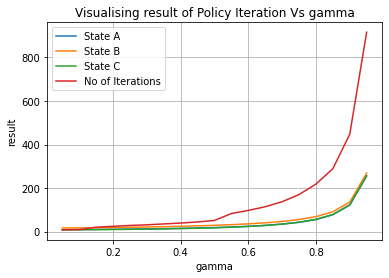

In [19]:
## Visualize policy iteration with multiple values of gamma
import matplotlib.pyplot as plt

results_POL_Iter_gamma, extra_info_POL_Iter_gamma = run_policy_iteration(env)

vizDict = {}
states = env.possible_states
gammas = sorted(results_POL_Iter_gamma.keys())

for state in states:
  vizDict[state] = []
vizDict["NIterations"] = []

for gamma in gammas:
  vizDict["NIterations"].append(extra_info_POL_Iter_gamma[gamma]["NIterations"])
  for state in states:
    vizDict[state].append(results_POL_Iter_gamma[gamma]["Expected Reward"][state])

for state in states:
  plt.plot(gammas, vizDict[state])
plt.plot(gammas, vizDict["NIterations"])

plt.xlabel("gamma")
plt.ylabel("result")
plt.title("Visualising result of Policy Iteration Vs gamma")
plt.grid(True)
plt.legend(list(map(lambda x: "State "+ x, states))+["No of Iterations"])
plt.show()

# Subjective questions


## 1.a How are values of $\gamma$ affecting results of policy iteration

Modify this cell/add code for your answer.

From the above plot we can see that as the gamma value increases the Final converged value or in case the result of Policy Iteration is also found to increase along with the increase in the number of iterations inorder to converge to that final value or result. From the graph we can also see a characteristic exponential increase in the final converged value with increase in gamma. (This is expected as discount factor >1 should cause it to diverge and go to infinity and this is convinced as we can extrapolate the graph and can realise it tends to touch a asymptote at gamma  = 1).

## 1.b For modified policy itetaration, do you find any improvement if you choose m=10.

Explain your answer

From the below graph with the increase in m, we can see that the final converged result increased (Actually tends towards the Policy iterations results with large m's) but this happens without the increase in the number of iterations (It is found to be constant of 3). As observed from graph it seems to asymtotically approach a upper value and that value is actually Policy iteration's convergence result which is the one expected and this happens without even increasing the number of iterations which is actually an improvement as we are getting a consistent result there after even with higher m values.

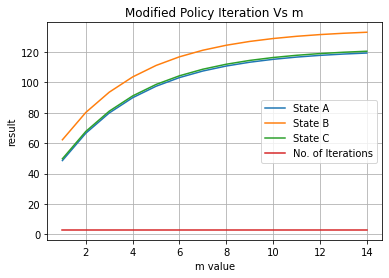

In [20]:
results_ModPOL_Iter_mValues, extra_info_ModPOL_Iter_mValues = run_modified_policy_iteration(env)

states = env.possible_states
mVals = sorted(results_ModPOL_Iter_mValues.keys())

vizDict = {}
for state in states:
  vizDict[state] = []
vizDict["mVals"]= []

for mVal in mVals:
  NIterations = extra_info_ModPOL_Iter_mValues[mVal]["NIterations"]
  vizDict["mVals"].append(NIterations)
  for state in states:
    vizDict[state].append(results_ModPOL_Iter_mValues[mVal]["Expected Reward"][state])

plt.figure(1)
plt.xlabel("m value")
plt.ylabel("result")
plt.title("Modified Policy Iteration Vs m")

for state in states:
  plt.plot(mVals, vizDict[state])
plt.plot(mVals, vizDict["mVals"])
plt.legend(list(map(lambda x: "State "+ x, states))+ ["No. of Iterations"])
plt.grid(True)
plt.show()

## 1.c Compare and contrast the behavior of Value Iteration and Gauss Seidel Value Iteraton

Add code/markdown as required

From the plots below we can see that irrespective of gamma both Value Iteration and Gauss Seidel Value Iteration are converging to the same final reward but they differ in the number of Iterations taken by them to converge. Gauss Seidel Value Iteration is found to converge faster than the Value Iteration. The difference is found to scale up with gamma and as gamma increases the Iterations needed to converge also increases consequently causing the difference in convergence between Value and Gauss Seidel Value Iteration is also found to increase.

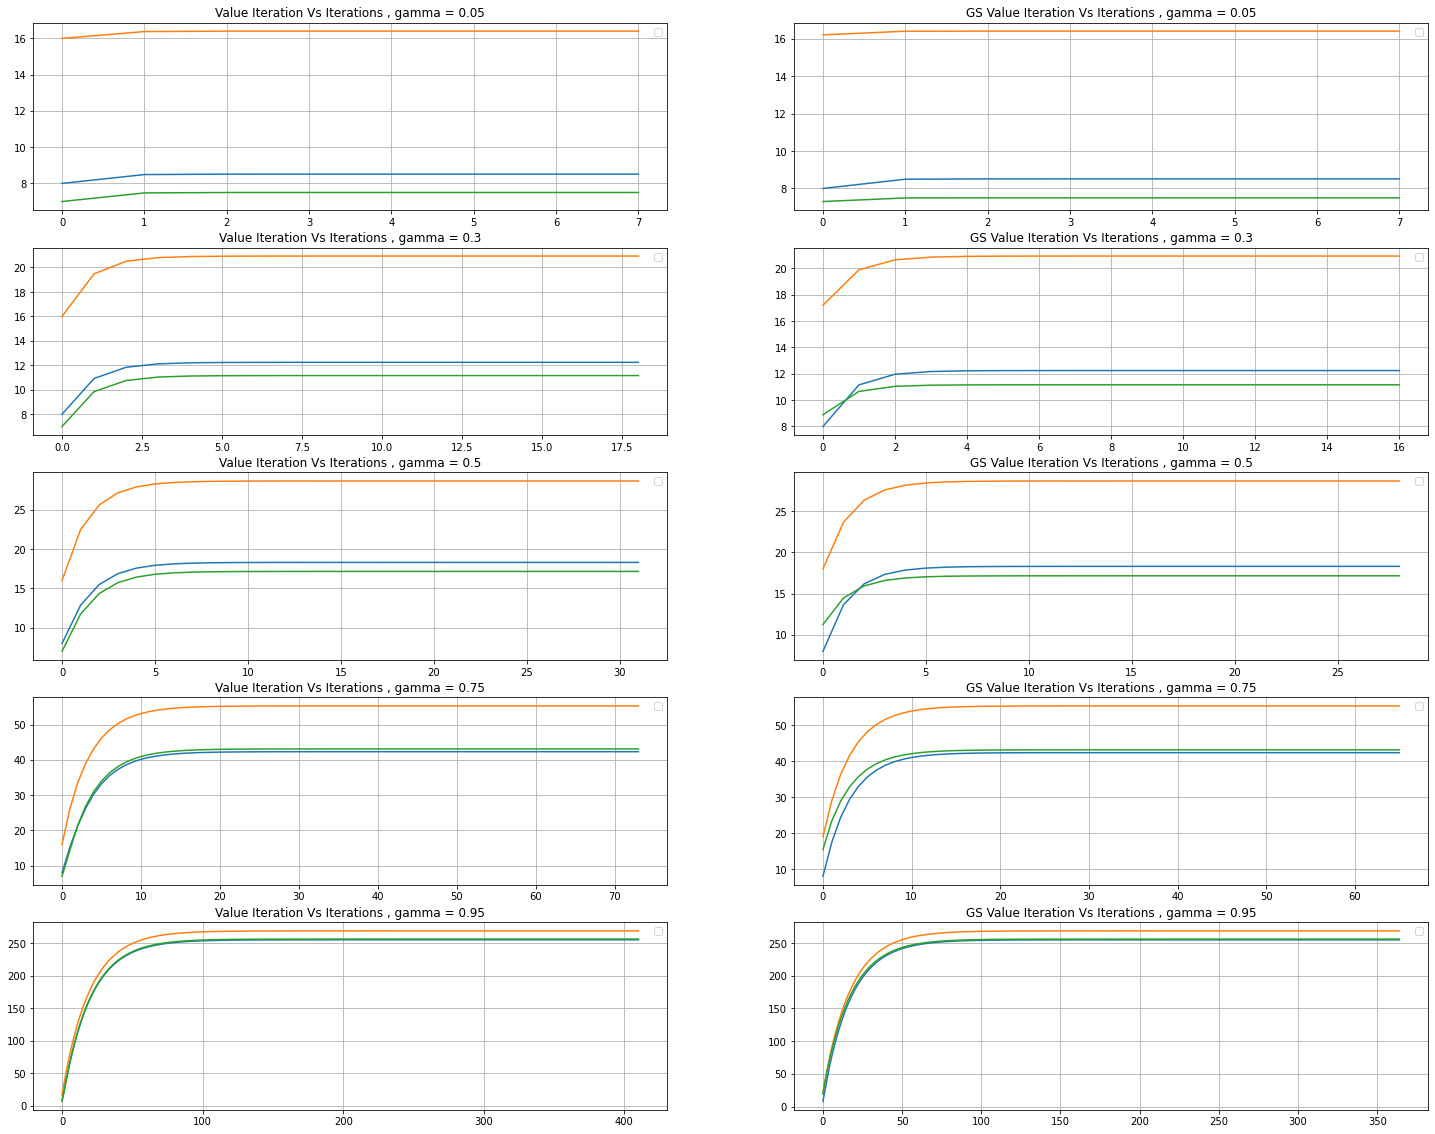

In [21]:
results_ValIter, extra_info_ValIter = run_value_iteration(env)
results_GS_ValIter, extra_info_GS_ValIter = run_gauss_seidel_value_iteration(env)

states = env.possible_states
gammas = sorted(results_ValIter.keys())
gammas = np.array(gammas).take([0,5, 9 ,-5,-1])

#ValueIter
vizDict1 = {}
for gamma in gammas:
  vizDict1[gamma] = {}
  for state in states:
    vizDict1[gamma][state] = []

for gamma in gammas:
  #Write data
  for state in states:
    for ele in extra_info_ValIter[gamma]["ValuesEvolution"]:
      vizDict1[gamma][state].append(ele[state])

#GaussSeidelValueIter
vizDict2 = {}
for gamma in gammas:
  vizDict2[gamma] = {}
  for state in states:
    vizDict2[gamma][state] = []

for gamma in gammas:
  #Write data
  for state in states:
    for ele in extra_info_GS_ValIter[gamma]["ValuesEvolution"]:
      vizDict2[gamma][state].append(ele[state])

#Plot
fig, a = plt.subplots(len(gammas),2, figsize = (25,20))
#aset(xlabel = "Iterations", ylabel = "results")
for enm,gamma in enumerate(gammas):
  for state in states:
    a[enm][0].plot(vizDict1[gamma][state])
    a[enm][0].grid(True)
    a[enm][0].legend(map(lambda x: "State "+ x, states))
    a[enm][1].plot(vizDict2[gamma][state])
    a[enm][1].grid(True)
    a[enm][1].legend(map(lambda x: "State "+ x, states))
  a[enm][0].set_title("Value Iteration Vs Iterations , gamma = "+str(round(gamma,2)))
  a[enm][1].set_title("GS Value Iteration Vs Iterations , gamma = "+str(round(gamma,2)))
plt.show()

# Submit to AIcrowd 🚀

In [ ]:
!DATASET_PATH=$AICROWD_DATASET_PATH aicrowd notebook submit -c iit-m-rl-assignment-2-taxi -a assets

No jupyter lab module found. Using jupyter notebook.
Using notebook: /content/AE17B030_IITM_Assignment_2_Taxi_Release.ipynb for submission...
Mounting Google Drive 💾
Your Google Drive will be mounted to access the colab notebook
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
